Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 


## Подготовка

In [1]:
!pip install xgboost

In [2]:
!pip install catboost

In [3]:
!pip install -Uq spacy

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import transformers as ppb
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [6]:
df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [7]:
df.duplicated().sum()

0

Пропусков и дубликатов нет.

In [8]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexander/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/alexander/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/alexander/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alexander/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Напишем функцию для лемматизации и очистки от лишних символов

In [9]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize(text):
    global nlp
    text = (re.sub(r'[^a-z]', ' ', text.lower()))
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [10]:
%%time
tqdm.pandas()
df['lemma_s'] = df['text'].progress_apply(lemmatize)

100%|███████████████████████████████████| 159292/159292 [58:00<00:00, 45.77it/s]

CPU times: user 14min 58s, sys: 7.23 s, total: 15min 5s
Wall time: 58min


In [11]:
df.head()

,Unnamed: 0,text,toxic,lemma_s
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I m se...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it ...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more I can t make any real suggestion on im...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you rememb...


In [12]:
stopwords = list(nltk_stopwords.words('english'))

Посчитаем TF-IDF для тренировочной и тестовой выборке текстов

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['lemma_s'], df['toxic'], test_size=0.3)

In [15]:
df['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

Применив функцию value_counts, мы видем, что у нас сильный дисбаланс классов. Проведем обучение моделий, взвесив классы внутренними методами.

## Обучение

Проверим разные алгоритмы с использованием внутренних методов взвешивания классов

### Class weight

#### LogisticRegression

In [16]:
pipeline_lg = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("clf", LogisticRegression(class_weight='balanced', random_state=42)),
    ]
)
pipeline_lg

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('clf',
                 LogisticRegression(class_weight='balanced', random_state=42))])

In [17]:
params_lg = {'clf__C': np.logspace(-3,3,7),
            'clf__penalty': ['l1', 'l2']}

In [18]:
grid_lg = GridSearchCV(pipeline_lg, param_grid=params_lg, cv=3, scoring='f1', n_jobs=-1)

grid_lg.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'clf__penalty': ['l1', 'l2']},
             scoring='f1')

In [19]:
best_result_lg = pd.DataFrame(grid_lg.cv_results_).sort_values('rank_test_score').head(1)
best_result_lg = best_result_lg[['mean_fit_time', 'params', 'mean_test_score']]
best_result_lg

,mean_fit_time,params,mean_test_score
9,4.810408,"{'clf__C': 10.0, 'clf__penalty': 'l2'}",0.759545


#### RandomForestClassifier

In [20]:
params = {'clf__max_depth': range(10, 51, 10),
         'clf__n_estimators': range(1000, 5001, 1000)}

In [21]:
pipeline_rf = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("clf", RandomForestClassifier(class_weight='balanced', random_state=42)),
    ]
)
pipeline_rf

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [22]:
grid_rf = GridSearchCV(pipeline_rf, param_grid=params, cv=3, scoring='f1', n_jobs=-1)

grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': range(10, 51, 10),
                         'clf__n_estimators': range(1000, 5001, 1000)},
             scoring='f1')

In [23]:
best_result_rf = pd.DataFrame(grid_rf.cv_results_).sort_values('rank_test_score').head(1)
best_result_rf = best_result_rf[['mean_fit_time', 'params', 'mean_test_score']]
best_result_rf

,mean_fit_time,params,mean_test_score
21,606.231917,"{'clf__max_depth': 50, 'clf__n_estimators': 2000}",0.501746


#### XGBClassifier

In [24]:
weight = y_train.value_counts(normalize=True)[0] * 100
weight

89.81381833835557

In [25]:
pipeline_xgbc = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("clf", XGBClassifier(scale_pos_weight=weight, random_state=42)),
    ]
)
pipeline_xgbc

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               co...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [26]:
grid_xgbc = GridSearchCV(pipeline_xgbc, param_grid=params, cv=3,  scoring='f1', n_jobs=-1)

grid_xgbc.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      bo...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': range(10, 51, 10),
                         'clf__n_estimators': range(1000, 5001, 1000)},
             scoring='f1')

In [27]:
best_result_xgbc = pd.DataFrame(grid_xgbc.cv_results_).sort_values('rank_test_score').head(1)
best_result_xgbc = best_result_xgbc[['mean_fit_time', 'params', 'mean_test_score']]
best_result_xgbc

,mean_fit_time,params,mean_test_score
2,26330.434843,"{'clf__max_depth': 10, 'clf__n_estimators': 3000}",0.772444


#### CatBoostClassifier

In [28]:
weights = [y_train.value_counts(normalize=True)[0], y_train.value_counts(normalize=True)[1]]
weights

[0.8981381833835558, 0.10186181661644425]

In [29]:
pipeline_ctbc = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("clf", CatBoostClassifier(auto_class_weights='Balanced', random_state=42, verbose=False)),
    ]
)
pipeline_ctbc

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x14cefe8b0>)])

In [30]:
grid_ctbc = GridSearchCV(pipeline_ctbc, param_grid=params, cv=3, scoring='f1', n_jobs=-1)

grid_ctbc.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('clf',
                                        <catboost.core.CatBoostClassifier object at 0x14cefe8b0>)]),
             n_jobs=-1,
             param_grid={'clf__max_depth': range(10, 51, 10),
                         'clf__n_estimators': range(1000, 5001, 1000)},
             scoring='f1')

In [31]:
best_result_ctbc = pd.DataFrame(grid_ctbc.cv_results_).sort_values('rank_test_score').head(1)
best_result_ctbc = best_result_ctbc[['mean_fit_time', 'params', 'mean_test_score']]
best_result_ctbc

,mean_fit_time,params,mean_test_score
4,58167.439047,"{'clf__max_depth': 10, 'clf__n_estimators': 5000}",0.776513


In [32]:
result = pd.concat([best_result_lg, best_result_rf, best_result_xgbc, best_result_ctbc])
result.index = ['LogisticRegression', 'RandomForestClassifier', 
                'XGBClassifier', 'CatBoostClassifier']
result

,mean_fit_time,params,mean_test_score
LogisticRegression,4.810408,"{'clf__C': 10.0, 'clf__penalty': 'l2'}",0.759545
RandomForestClassifier,606.231917,"{'clf__max_depth': 50, 'clf__n_estimators': 2000}",0.501746
XGBClassifier,26330.434843,"{'clf__max_depth': 10, 'clf__n_estimators': 3000}",0.772444
CatBoostClassifier,58167.439047,"{'clf__max_depth': 10, 'clf__n_estimators': 5000}",0.776513


Три модели показали скор выше заданного порога на тренировочной выборке. Время обучения бустингов очень большое, применим метод уменьшения выборки за счет класса большинства.

### Under sampling

In [33]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

In [34]:
X_resampled = X_resampled['lemma_s']

#### LogisticRegression

In [35]:
pipeline_lg_us = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("clf", LogisticRegression(random_state=42)),
    ]
)
pipeline_lg_us

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('clf', LogisticRegression(random_state=42))])

In [36]:
grid_lg_us = GridSearchCV(pipeline_lg_us, param_grid=params_lg, cv=3, scoring='f1', n_jobs=-1)

grid_lg_us.fit(X_resampled, y_resampled)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'clf__penalty': ['l1', 'l2']},
             scoring='f1')

In [37]:
best_result_lg_us = pd.DataFrame(grid_lg_us.cv_results_).sort_values('rank_test_score').head(1)
best_result_lg_us = best_result_lg_us[['mean_fit_time', 'params', 'mean_test_score']]
best_result_lg_us

,mean_fit_time,params,mean_test_score
9,1.103844,"{'clf__C': 10.0, 'clf__penalty': 'l2'}",0.892037


#### RandomForestClassifier

In [38]:
pipeline_rf_us = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("clf", RandomForestClassifier(random_state=42)),
    ]
)
pipeline_rf_us

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('clf', RandomForestClassifier(random_state=42))])

In [39]:
grid_rf_us = GridSearchCV(pipeline_rf_us, param_grid=params, cv=3, scoring='f1', n_jobs=-1)

grid_rf_us.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': range(10, 51, 10),
                         'clf__n_estimators': range(1000, 5001, 1000)},
             scoring='f1')

In [40]:
best_result_rf_us = pd.DataFrame(grid_rf_us.cv_results_).sort_values('rank_test_score').head(1)
best_result_rf_us = best_result_rf_us[['mean_fit_time', 'params', 'mean_test_score']]
best_result_rf_us

,mean_fit_time,params,mean_test_score
22,110.797886,"{'clf__max_depth': 50, 'clf__n_estimators': 3000}",0.841551


#### XGBClassifier

In [41]:
pipeline_xgbc_us = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("clf", XGBClassifier(random_state=42)),
    ]
)
pipeline_xgbc_us

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               co...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [42]:
grid_xgbc_us = GridSearchCV(pipeline_xgbc_us, param_grid=params, cv=3,  scoring='f1', n_jobs=-1)

grid_xgbc_us.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      bo...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': range(10, 51, 10),
                         'clf__n_estimators': range(1000, 5001, 1000)},
             scoring='f1')

In [43]:
best_result_xgbc_us = pd.DataFrame(grid_xgbc_us.cv_results_).sort_values('rank_test_score').head(1)
best_result_xgbc_us = best_result_xgbc_us[['mean_fit_time', 'params', 'mean_test_score']]
best_result_xgbc_us

,mean_fit_time,params,mean_test_score
0,124.712472,"{'clf__max_depth': 10, 'clf__n_estimators': 1000}",0.882303


#### CatBoostClassifier

In [44]:
pipeline_ctbc_us = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("clf", CatBoostClassifier(random_state=42, verbose=False)),
    ]
)
pipeline_ctbc_us

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x14f572e80>)])

In [45]:
grid_ctbc_us = GridSearchCV(pipeline_ctbc_us, param_grid=params, cv=3, scoring='f1', n_jobs=-1)

grid_ctbc_us.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('clf',
                                        <catboost.core.CatBoostClassifier object at 0x14f572e80>)]),
             n_jobs=-1,
             param_grid={'clf__max_depth': range(10, 51, 10),
                         'clf__n_estimators': range(1000, 5001, 1000)},
             scoring='f1')

In [46]:
best_result_ctbc_us = pd.DataFrame(grid_ctbc_us.cv_results_).sort_values('rank_test_score').head(1)
best_result_ctbc_us = best_result_ctbc_us[['mean_fit_time', 'params', 'mean_test_score']]
best_result_ctbc_us

,mean_fit_time,params,mean_test_score
3,11528.413744,"{'clf__max_depth': 10, 'clf__n_estimators': 4000}",0.888803


In [61]:
result_us = pd.concat([best_result_lg_us, best_result_rf_us, 
                       best_result_xgbc_us, best_result_ctbc_us])
result_us.index = ['LogisticRegression_us', 'RandomForestClassifier_us', 
                'XGBClassifier_us', 'CatBoostClassifier_us']
result_us

,mean_fit_time,params,mean_test_score
LogisticRegression_us,1.103844,"{'clf__C': 10.0, 'clf__penalty': 'l2'}",0.892037
RandomForestClassifier_us,110.797886,"{'clf__max_depth': 50, 'clf__n_estimators': 3000}",0.841551
XGBClassifier_us,124.712472,"{'clf__max_depth': 10, 'clf__n_estimators': 1000}",0.882303
CatBoostClassifier_us,11528.413744,"{'clf__max_depth': 10, 'clf__n_estimators': 4000}",0.888803


При применении undersampling мы получили более лучшие результаты, чем при взвешивании классов. Проверим по разному обученные модели на тестовой выборке.

In [65]:
pd.concat([result, result_us]).sort_index()

,mean_fit_time,params,mean_test_score
CatBoostClassifier,58167.439047,"{'clf__max_depth': 10, 'clf__n_estimators': 5000}",0.776513
CatBoostClassifier_us,11528.413744,"{'clf__max_depth': 10, 'clf__n_estimators': 4000}",0.888803
LogisticRegression,4.810408,"{'clf__C': 10.0, 'clf__penalty': 'l2'}",0.759545
LogisticRegression_us,1.103844,"{'clf__C': 10.0, 'clf__penalty': 'l2'}",0.892037
RandomForestClassifier,606.231917,"{'clf__max_depth': 50, 'clf__n_estimators': 2000}",0.501746
RandomForestClassifier_us,110.797886,"{'clf__max_depth': 50, 'clf__n_estimators': 3000}",0.841551
XGBClassifier,26330.434843,"{'clf__max_depth': 10, 'clf__n_estimators': 3000}",0.772444
XGBClassifier_us,124.712472,"{'clf__max_depth': 10, 'clf__n_estimators': 1000}",0.882303


In [52]:
pd.DataFrame({'test_score':[f1_score(y_test, grid_lg.predict(X_test)),
              f1_score(y_test, grid_rf.predict(X_test)),
              f1_score(y_test, grid_xgbc.predict(X_test)),
              f1_score(y_test, grid_ctbc.predict(X_test))],
              'test_score_us':[f1_score(y_test, grid_lg_us.predict(X_test)),
              f1_score(y_test, grid_rf_us.predict(X_test)),
              f1_score(y_test, grid_xgbc_us.predict(X_test)),
              f1_score(y_test, grid_ctbc_us.predict(X_test))]},
            index=['LogisticRegression', 'RandomForestClassifier',
                   'XGBClassifier', 'CatBoostClassifier'])

,test_score,test_score_us
LogisticRegression,0.764909,0.681405
RandomForestClassifier,0.491613,0.509728
XGBClassifier,0.776777,0.675671
CatBoostClassifier,0.775867,0.731531


Как можно заметить модели обученные на меньшем количестве наблюдений с использованием метода выравнивания классов за счет уменьшения класса большинства переобучились на тренировочной выборке и на тестовой показали результаты хуже, чем те, которые тренировались намного дольше на всей выборке с методом взвешивания классов.

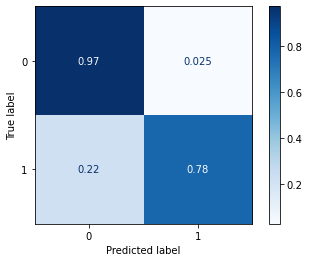

In [54]:
ConfusionMatrixDisplay.from_predictions(y_test, grid_xgbc.predict(X_test),
                                        display_labels=grid_xgbc.classes_, cmap='Blues',
                                       normalize='true');

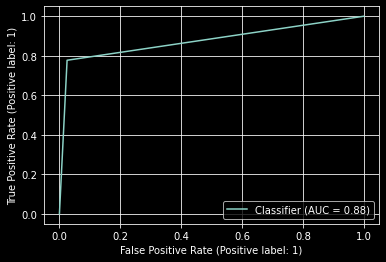

In [58]:
plt.style.use('dark_background')
RocCurveDisplay.from_predictions(y_test, grid_xgbc.predict(X_test))
plt.grid();

## Выводы

Провели анализ данной выборки, пропусков и дубликатов обнаружено не было. Затем обработали текст, лемматизировав слова и убрав лишние. Преобразовали отзывы в векторы для обучения модели и дальнейших предсказаний. Т.к. в выборке был обнаружен сильный дисбаланс классов, во время обучения были применены методы взвешивания классов и уменьшения выборки за счет класса большинства. По итогам обучения модели, обученные на уменьшенной выборке показали наилучшие результаты, но ни одна ни показала необходимый результат на тестовой, что свидетельствует о переобучении. Из тех моделий, которые обучались с использованием методов взвешивания классов, лучших результатов доюились бустинги как на тренировочной, так и на тестовой выборках. Исходя из того, что XGBClassifier обучался в два быстрее, чем CatboostClassifier и показал наилучший результат на тестовой выборке 0,776777, отдадим предпочтение ему.